In [1]:
import pandas as pd

In [2]:
df_bank = pd.read_csv("data/bank-full.csv", delimiter=";")

In [3]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df_bank, test_size=0.25, random_state=123)

In [4]:
train_df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
26999,32,unemployed,single,secondary,no,2706,no,no,cellular,21,nov,462,3,-1,0,unknown,no
16168,37,admin.,married,secondary,no,1396,yes,no,cellular,22,jul,199,2,-1,0,unknown,no
12338,22,blue-collar,married,secondary,no,-295,yes,no,unknown,26,jun,150,2,-1,0,unknown,no
6074,36,blue-collar,married,secondary,no,-870,yes,no,unknown,26,may,102,2,-1,0,unknown,no
7385,50,admin.,married,primary,no,429,no,no,unknown,29,may,60,2,-1,0,unknown,no


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33908 entries, 26999 to 15725
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        33908 non-null  int64 
 1   job        33908 non-null  object
 2   marital    33908 non-null  object
 3   education  33908 non-null  object
 4   default    33908 non-null  object
 5   balance    33908 non-null  int64 
 6   housing    33908 non-null  object
 7   loan       33908 non-null  object
 8   contact    33908 non-null  object
 9   day        33908 non-null  int64 
 10  month      33908 non-null  object
 11  duration   33908 non-null  int64 
 12  campaign   33908 non-null  int64 
 13  pdays      33908 non-null  int64 
 14  previous   33908 non-null  int64 
 15  poutcome   33908 non-null  object
 16  y          33908 non-null  object
dtypes: int64(7), object(10)
memory usage: 4.7+ MB


In [6]:
# Distribution of the target

In [7]:
train_df["y"].value_counts(normalize=True)

y
no     0.882358
yes    0.117642
Name: proportion, dtype: float64

In [8]:
# Distributions of categorical and numeric features

In [9]:
categorical_cols = list(train_df.drop(columns=["y"]).select_dtypes(include=["object"]).columns)
numerical_cols = list(train_df.select_dtypes(include=["int64"]).columns)

In [10]:
import altair as alt
alt.data_transformers.enable("vegafusion")

alt.Chart(train_df).mark_bar().encode(
    x="count()",
    y=alt.Y(alt.repeat()).type("nominal")
).repeat(
    categorical_cols, columns=3
)

alt.RepeatChart(...)

In [11]:
alt.Chart(train_df).mark_bar().encode(
    x=alt.X(alt.repeat()).type("quantitative").bin(maxbins=40),
    y="count()"
).repeat(
    numerical_cols, columns=3
)

alt.RepeatChart(...)

In [12]:
# Correlations between numeric features

In [13]:
# measure linear relationship
person_corr_df = train_df[numerical_cols].corr("pearson").unstack().reset_index()
person_corr_df.columns = ["num_variable_0", "num_variable_1", "correlation"]

corr_heatmap = alt.Chart(person_corr_df).mark_rect().encode(
    x=alt.X("num_variable_0").title("Numerical Variable"),
    y=alt.Y("num_variable_1").title("Numerical Variable"),
    color="correlation:Q"
).properties(
    width=250,
    height=250
)

text = alt.Chart(person_corr_df, title="Pearson Correlation").mark_text().encode(
    x=alt.X("num_variable_0").title("Numerical Variable"),
    y=alt.Y("num_variable_1").title("Numerical Variable"),
    text=alt.Text("correlation:Q", format=".2f")
)

corr_heatmap + text

alt.LayerChart(...)

In [14]:
# measure monotonic (incl. non-linear) relationship
# FIXME: does it matter? If we apply linear models, we're more afraid of collinearity, i.e. linear relationship
spearman_corr_df = train_df[numerical_cols].corr("spearman").unstack().reset_index()
spearman_corr_df.columns = ["num_variable_0", "num_variable_1", "correlation"]

corr_heatmap = alt.Chart(spearman_corr_df, title="Spearman Correlation").mark_rect().encode(
    x=alt.X("num_variable_0").title("Numerical Variable"),
    y=alt.Y("num_variable_1").title("Numerical Variable"),
    color="correlation:Q"
).properties(
    width=250,
    height=250
)

text = alt.Chart(spearman_corr_df).mark_text().encode(
    x=alt.X("num_variable_0").title("Numerical Variable"),
    y=alt.Y("num_variable_1").title("Numerical Variable"),
    text=alt.Text("correlation:Q", format=".2f")
)

corr_heatmap + text

alt.LayerChart(...)

In [15]:
# checking for correlation between pdays and previous
# FIXME: there is no linear relationship here
pdays_prev = alt.Chart(train_df, title="pdays vs previous").mark_point().encode(
    x="pdays",
    y="previous"
)

pdays_prev_clamped = alt.Chart(train_df, title="pdays vs previous (previous <= 50)").mark_point().encode(
    x="pdays",
    y=alt.Y("previous").scale(domain=(0, 50), clamp=True)
)

pdays_prev | pdays_prev_clamped

alt.HConcatChart(...)

### Summary and Recommendations from EDA
- Generally, bar charts were created for categorical variables, and histograms for numerical variables to show illustration. Correlation heatmaps based on two different metrics were generated to investigate the relationships between numerical variables. A scatter plot specifically for `pdays` vs `previous` was created.
- Judging from the proportion of each class in the target, the dataset is unbalanced
- `job`, `education`, `contact` and `poutcome` contain unknown values. We do not have enough information on the dataset to impute these values properly. Note that these values are not null values, but strings called "unknown". **# FIXME: it seems only `contact` and `poutcome` have "unknown"**
- Out of the columns mentioned that contain unknown values, `contact` and `poutcome` need to be dropped since they contain too many unknown examples. We cannot just drop the unknowns from these columns since we would be dropping too many examples, especially considering the size of the data. **# FIXME: `poutcome` is the outcome of the previous marketing campaign. Most of the "unknown" is because `previous = 0`. If the person has never been contacted for marketing before, it makes sense to say "unknown" for this field as "previous marketing" doesn't exist. But for those who have been reached out before, this `poutcome` might be informative! On the other hand, I think `contact` could be kept, because not that many "unknown" in it actually. Also, our task is to find out the importance of features. There should be no farm to keep it, but I would expect the result to tell me that this `contact` is not important.**
- `job` and `education` can be kept. We can just drop the unknowns from these features. **# FIXME: they might contain information too?**
- The distributions of `pdays` and `previous` are heavily skewed. These variables are also correlated with 0.99 Spearman correlation score and 0.44 Pearson correlation score.
- However, upon visual inspection with a scatter plot, `pdays` and `previous` do not seem to be too correlated to be an issue. We can keep them both as features.
- Overall recommendations:
   - Drop `contact` and `poutcome`
   - Drop unknown values from `job` and `education`
   - Ordinal encode `education`
   - One-hot encode other categorical variables
   - Standardize numerical columns

In [16]:
# train_df = train_df.loc[(train_df["job"] != "unknown") & (train_df["education"] != "unknown")]
# test_df = test_df.loc[(test_df["job"] != "unknown") & (test_df["education"] != "unknown")]

# X_train = train_df.drop(columns=["y"])
# y_train = train_df["y"]
# X_test = test_df.drop(columns=["y"])
# y_test = test_df["y"]

In [17]:
# from sklearn.compose import make_column_transformer
# from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

# # recommended transformations
# categorical_feats = ["job", "marital", "default", "housing", "loan", "month"]
# ordinal_feats = ["education"]
# drop_feats = ["contact", "poutcome"]
# numerical_feats = numerical_cols

# education_levels = ["primary", "secondary", "tertiary"]

# col_transformer = make_column_transformer((OneHotEncoder(sparse_output=False, drop="if_binary"), categorical_feats),
#                                           (OrdinalEncoder(categories=[education_levels], dtype=int), ordinal_feats),
#                                           ("drop", drop_feats),
#                                           (StandardScaler(), numerical_feats))

In [18]:
X_train, y_train = train_df.drop(columns=["y"]), train_df["y"]
X_test, y_test = test_df.drop(columns=["y"]), test_df["y"]

In [26]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

categorical_feats = ["job", "marital", "default", "housing", "loan", "contact", "day", "month", "poutcome"]
ordinal_feats = ["education"]
numeric_feats = ["age", "balance", "duration", "campaign", "previous", "pdays"]

education_levels = ["unknown", "primary", "secondary", "tertiary"]

preprocessor = make_column_transformer(
    (OneHotEncoder(sparse_output=False, drop="if_binary"), categorical_feats),
    (OrdinalEncoder(categories=[education_levels], dtype=int), ordinal_feats),
    (StandardScaler(), numeric_feats)
)

# logistic regression

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

lr_pipe = make_pipeline(
    preprocessor,
    LogisticRegression(random_state=123, max_iter=2000)
)

lr_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'day', 'month',
                                                   'poutcome']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                                                              'tertiary']],
                                                                 dtype=<class 'int'>),
                                                  ['education']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'previous',
                                                   'pdays'])])),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=123))])

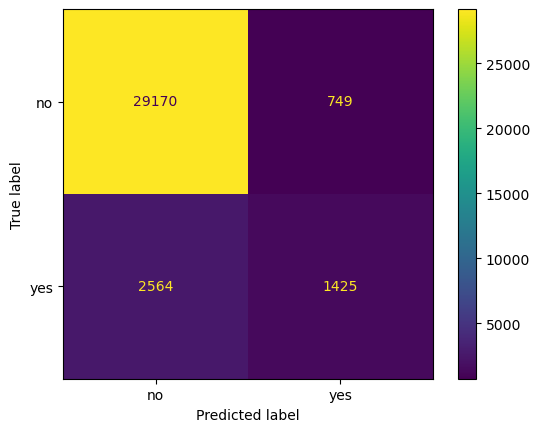

In [33]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

ConfusionMatrixDisplay.from_estimator(lr_pipe, X_train, y_train)

In [43]:
y_pred = lr_pipe.predict(X_train)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

          no       0.92      0.97      0.95     29919
         yes       0.66      0.36      0.46      3989

    accuracy                           0.90     33908
   macro avg       0.79      0.67      0.70     33908
weighted avg       0.89      0.90      0.89     33908



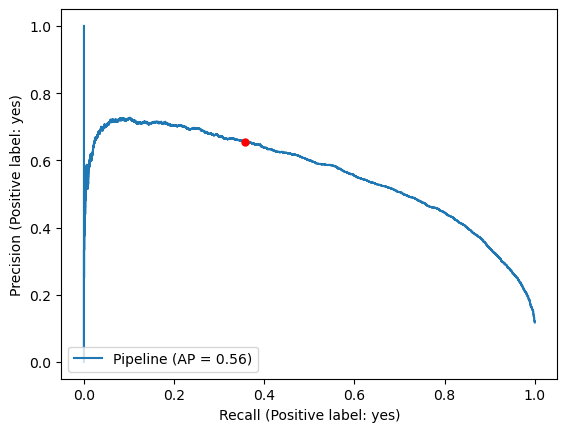

In [50]:
from sklearn.metrics import PrecisionRecallDisplay, average_precision_score, recall_score, precision_score
import matplotlib.pyplot as plt
PrecisionRecallDisplay.from_estimator(lr_pipe, X_train, y_train)

# plot point
plt.plot(recall_score(y_train, y_pred, pos_label="yes"), precision_score(y_train, y_pred, pos_label="yes"), "ro", markersize=5) # red circle


In [53]:
lr_pipe.named_steps['logisticregression'].coef_

array([[ 1.16878928e-01, -1.79892630e-01, -1.00795455e-01,
        -4.02453392e-01,  1.35345252e-02,  3.20317275e-01,
        -1.13888017e-01, -1.15801444e-01,  5.34287084e-01,
        -6.50242632e-02, -7.82041117e-02,  7.53587235e-02,
        -9.90018425e-04, -1.40886393e-01,  1.46193634e-01,
        -9.05063981e-02, -6.58338937e-01, -4.08702275e-01,
         5.78368839e-01,  3.89146410e-01, -9.63198027e-01,
        -1.02415215e-01, -1.21608526e-01,  1.33978506e-01,
         8.25367741e-02, -2.76831005e-01, -1.57919870e-01,
        -3.22841711e-01, -5.15126028e-02, -5.06028453e-02,
         4.57716560e-01, -8.84962991e-02,  2.70490083e-01,
         2.82111800e-01,  6.07825685e-02,  1.09306107e-01,
         3.69668729e-02, -6.15797292e-01, -2.00371914e-01,
        -6.02538995e-01, -5.44517250e-01, -9.09077530e-02,
         3.99417111e-02,  3.91652705e-01, -9.20134253e-02,
         3.37933267e-01,  1.82628142e-01,  5.65919469e-01,
         3.08304027e-02, -1.49247296e-01,  4.15409524e-0

In [62]:
lr_pipe.named_steps['columntransformer'].named_transformers_

{'onehotencoder': OneHotEncoder(drop='if_binary', sparse_output=False),
 'ordinalencoder': OrdinalEncoder(categories=[['unknown', 'primary', 'secondary', 'tertiary']],
                dtype=<class 'int'>),
 'standardscaler': StandardScaler()}

In [73]:
categorical_cols = lr_pipe.named_steps['columntransformer'].named_transformers_['onehotencoder'].get_feature_names_out().tolist()
ordinal_cols = lr_pipe.named_steps['columntransformer'].named_transformers_['ordinalencoder'].get_feature_names_out().tolist()
numeric_cols = lr_pipe.named_steps['columntransformer'].named_transformers_['standardscaler'].get_feature_names_out().tolist()

feature_importance = pd.DataFrame({
    'feature': categorical_cols + ordinal_cols + numeric_cols, 
    'coef': lr_pipe.named_steps['logisticregression'].coef_[0].tolist()
})
feature_importance

,feature,coef
0,job_admin.,0.116879
1,job_blue-collar,-0.179893
2,job_entrepreneur,-0.100795
3,job_housemaid,-0.402453
4,job_management,0.013535
...,...,...
70,balance,0.038570
71,duration,1.084148
72,campaign,-0.289060
73,previous,0.017589


In [76]:
pd.set_option('display.max_rows', 100)
feature_importance.sort_values('coef', ascending=False)

,feature,coef
66,poutcome_success,1.607427
59,month_mar,1.457385
71,duration,1.084148
62,month_oct,0.844451
63,month_sep,0.777936
54,month_dec,0.605353
18,contact_cellular,0.578369
47,day_27,0.565919
8,job_student,0.534287
30,day_10,0.457717


In [117]:
feature_importance.sort_values('importance', ascending=False)

,feature,importance
71,duration,0.542277
66,poutcome_success,0.296625
59,month_mar,0.047206
69,age,0.037575
62,month_oct,0.030507
20,contact_unknown,0.021793
16,housing_yes,0.005583
70,balance,0.005371
60,month_may,0.004175
72,campaign,0.001820


# decision tree

In [101]:
from sklearn.tree import DecisionTreeClassifier

dt_pipe = make_pipeline(
    preprocessor,
    DecisionTreeClassifier(random_state=123, max_depth=5)
)
dt_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                sparse_output=False),
                                                  ['job', 'marital', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'day', 'month',
                                                   'poutcome']),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(categories=[['unknown',
                                                                              'primary',
                                                                              'secondary',
                                                                              'tertiary']],
                                                                 dtype=<class 'int'>),
                                                  ['education']),
                                                 ('standardscaler',
                                                  StandardScaler(),
                                                  ['age', 'balance', 'duration',
                                                   'campaign', 'previous',
                                                   'pdays'])])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, random_state=123))])

In [102]:
# from sklearn.tree import plot_tree
# plt.figure(figsize=(12,12))
# plot_tree(dt_pipe.named_steps['decisiontreeclassifier'], feature_names=categorical_cols + ordinal_cols + numeric_cols, fontsize=10)
# plt.show()

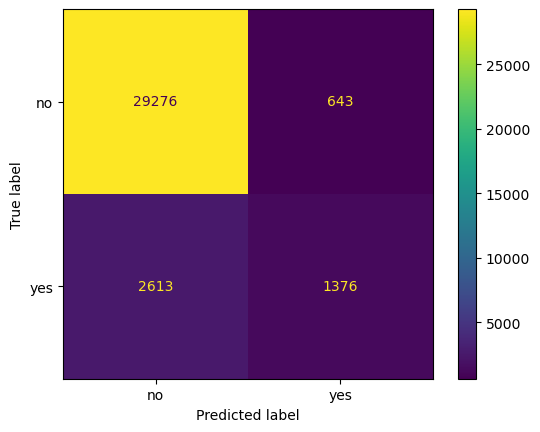

In [103]:
ConfusionMatrixDisplay.from_estimator(dt_pipe, X_train, y_train)

In [104]:
print(classification_report(y_train, dt_pipe.predict(X_train)))

              precision    recall  f1-score   support

          no       0.92      0.98      0.95     29919
         yes       0.68      0.34      0.46      3989

    accuracy                           0.90     33908
   macro avg       0.80      0.66      0.70     33908
weighted avg       0.89      0.90      0.89     33908



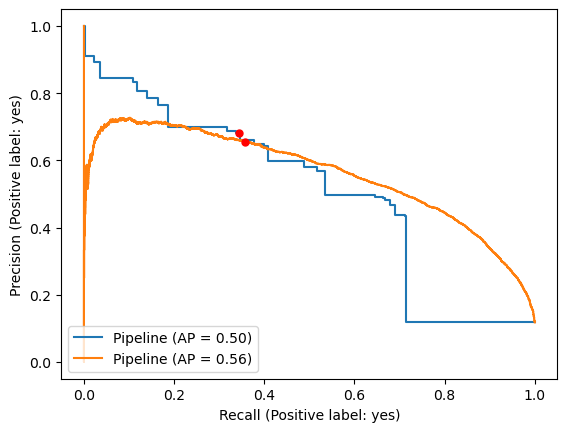

In [111]:
_, ax = plt.subplots()

PrecisionRecallDisplay.from_estimator(dt_pipe, X_train, y_train, ax=ax)

# plot point
plt.plot(
    recall_score(y_train, dt_pipe.predict(X_train), pos_label="yes"), 
    precision_score(y_train, dt_pipe.predict(X_train), pos_label="yes"), 
    "ro", markersize=5) # red circle

PrecisionRecallDisplay.from_estimator(lr_pipe, X_train, y_train, ax=ax)

# plot point
plt.plot(recall_score(y_train, y_pred, pos_label="yes"), precision_score(y_train, y_pred, pos_label="yes"), "ro", markersize=5) # red circle

In [116]:
feature_importance = pd.DataFrame({
    'feature': categorical_cols + ordinal_cols + numeric_cols, 
    'importance': dt_pipe.named_steps['decisiontreeclassifier'].feature_importances_.tolist()
})
feature_importance.sort_values('importance', ascending=False)

,feature,importance
71,duration,0.542277
66,poutcome_success,0.296625
59,month_mar,0.047206
69,age,0.037575
62,month_oct,0.030507
20,contact_unknown,0.021793
16,housing_yes,0.005583
70,balance,0.005371
60,month_may,0.004175
72,campaign,0.001820


# cross-validation on precision

In [120]:
?cross_validate

Signature:
cross_validate(
    estimator,
    X,
    y=None,
    *,
    groups=None,
    scoring=None,
    cv=None,
    n_jobs=None,
    verbose=0,
    fit_params=None,
    pre_dispatch='2*n_jobs',
    return_train_score=False,
    return_estimator=False,
    return_indices=False,
    error_score=nan,
)
Docstring:
Evaluate metric(s) by cross-validation and also record fit/score times.

Read more in the :ref:`User Guide <multimetric_cross_validation>`.

Parameters
----------
estimator : estimator object implementing 'fit'
    The object to use to fit the data.

X : {array-like, sparse matrix} of shape (n_samples, n_features)
    The data to fit. Can be for example a list, or an array.

y : array-like of shape (n_samples,) or (n_samples, n_outputs), default=None
    The target variable to try to predict in the case of
    supervised learning.

groups : array-like of shape (n_samples,), default=None
    Group labels for the samples used while splitting the dataset into
    train/test set.

In [135]:
import numpy as np
#(lambda y: pd.Series(np.where(y, "yes", "no"), name="y"))
((lambda y: y == "yes")(y_train))

26999    False
16168    False
12338    False
6074     False
7385     False
         ...  
7763      True
15377    False
17730    False
28030    False
15725    False
Name: y, Length: 33908, dtype: bool

In [133]:
y_train

26999     no
16168     no
12338     no
6074      no
7385      no
        ... 
7763     yes
15377     no
17730     no
28030     no
15725     no
Name: y, Length: 33908, dtype: object

In [139]:
y_train=="yes"

26999    False
16168    False
12338    False
6074     False
7385     False
         ...  
7763      True
15377    False
17730    False
28030    False
15725    False
Name: y, Length: 33908, dtype: bool

In [148]:
from sklearn.model_selection import cross_validate

lr_pipe = make_pipeline(preprocessor, LogisticRegression(random_state=123, max_iter=2000))

pd.DataFrame(
    cross_validate(lr_pipe, X_train, y_train=="yes", cv=10, return_train_score=True, scoring=["accuracy", "precision", "recall"])
).agg(['mean']).round(3).T

,mean
fit_time,0.334
score_time,0.009
test_accuracy,0.902
train_accuracy,0.902
test_precision,0.652
train_precision,0.656
test_recall,0.355
train_recall,0.358


In [147]:
pd.DataFrame(
    cross_validate(dt_pipe, X_train, y_train=="yes", cv=10, return_train_score=True, scoring=["accuracy", "precision", "recall"])
).agg(['mean']).round(3).T

,mean
fit_time,0.113
score_time,0.009
test_accuracy,0.901
train_accuracy,0.904
test_precision,0.646
train_precision,0.671
test_recall,0.353
train_recall,0.370
